In [531]:
import topogenesis as tg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [532]:
# create an array of 0
width = 56
length = 56
avail_array = np.zeros((width,length,1), dtype=int)
p_array = np.copy(avail_array)

In [533]:
# create array every i cells
def grid(i):
    array = np.array(avail_array, copy=True)
    array[0::i,::i] = 1
    array[::i,i-1::i] = 2
    array[i-1::i,i-1::i] = 3
    array[i-1::i,::i] = 4
    return array

In [534]:
# create 8 cell array
eight_array = grid(8)

# create 2 cell array
two_array = grid(2)

In [535]:
def plot(array_x):
    fig, ax = plt.subplots()
    plt.imshow(array_x)
    for x in range(50):
        ax.axhline(x, lw=0.1, color='k', zorder=5)
        ax.axvline(x, lw=0.1, color='k', zorder=5)
    plt.colorbar()
    plt.show()

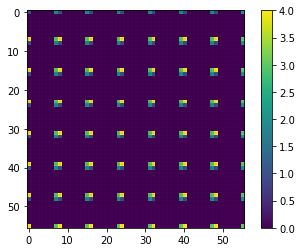

In [536]:
plot(eight_array)

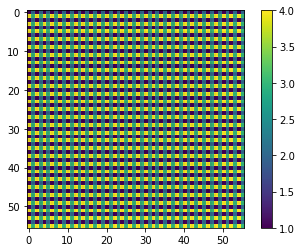

In [537]:
plot(two_array)

In [538]:
first_column = eight_array[::,0]
a = np.argwhere(first_column ==1)
point = a[len(a)//2]

In [539]:
def courtyard(point):
    c = (8,8,1)
    avail_array[point[0]:point[0] + c[0], point[1]:point[1] + c[1]] = 1

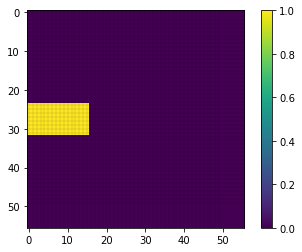

In [540]:
courtyard(point)
point_2 = (point[0], point[1]+8, 1)
courtyard(point_2)
plot(avail_array)

In [541]:
avail_lattice = tg.to_lattice(avail_array, minbound=[0,0,0])

In [542]:
up_s = tg.create_stencil("moore", 2, 2)
up_s.function = tg.sfunc.sum 

In [543]:
vn_stencil = tg.create_stencil("von_neumann", 1, 1)
vn_stencil[1, 1, 1] = 0
vn_stencil[1, 1, :] = 0
vn_stencil.function = tg.sfunc.sum 

In [544]:
neigh2_lattice = avail_lattice.apply_stencil(up_s)

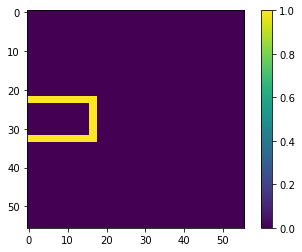

In [545]:
plt.imshow((neigh2_lattice[:,:,0]>=1) * (avail_lattice[:,:,0]==0))
plt.colorbar()
plt.show()

In [546]:
# apply corridor 
corridor = np.argwhere((neigh2_lattice[:,:,0]>=1) * (avail_lattice[:,:,0]==0))
for i in range(len(corridor)):
    avail_array[corridor[i][0],corridor[i][1]] = 2

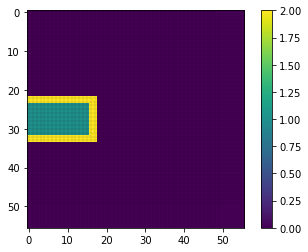

In [547]:
plot(avail_array)

In [548]:
avail_lattice = tg.to_lattice(avail_array, minbound=[0,0,0])
neigh_lattice = avail_lattice.apply_stencil(vn_stencil)

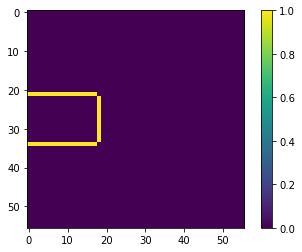

In [549]:
plt.imshow(neigh_lattice == 2)
plt.colorbar()
plt.show()

In [550]:
def find_possible_p(new_lattice, array, avail, i):
    # points where we have neighbours and number 1s (down and side cells)
    points_2 = np.argwhere(((new_lattice == i)*(array == 1)*(avail == 0)) == 1)

    # points where we have neighbours and number 3s (up cells) - find 1s to apply spaces
    points_3 = np.argwhere(((new_lattice == i)*(array == 3)*(avail == 0)) == 1)
    point_A = points_3[:][:]-[7,7,0]
    neg = np.where(point_A[:][:] < 0)
    point_A = np.delete(point_A, neg, axis=0)

    # all points together
    p = np.append(points_2, point_A, axis=0)
    return p

In [551]:
p = find_possible_p(neigh_lattice, two_array, avail_array, 2)
print(p)

[[22 18  0]
 [24 18  0]
 [26 18  0]
 [28 18  0]
 [30 18  0]
 [32 18  0]
 [34  0  0]
 [34  2  0]
 [34  4  0]
 [34  6  0]
 [34  8  0]
 [34 10  0]
 [34 12  0]
 [34 14  0]
 [34 16  0]
 [14  0  0]
 [14  2  0]
 [14  4  0]
 [14  6  0]
 [14  8  0]
 [14 10  0]]


In [552]:
# definition of public spaces with 8*8 m2 (top starting point, index number)
def public(point,i):
    c = (8,8,1)
    avail_array[point[0]:point[0] + c[0], point[1]:point[1] + c[1]] = i

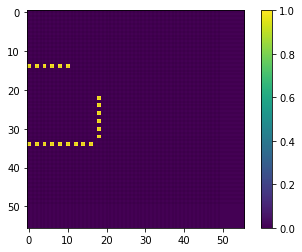

In [553]:
# array of possible points
p_array = np.zeros((width,length,1), dtype=int)
for i in range(len(p)):
    p_array[p[i][0], p[i][1]] = 1
plot(p_array)

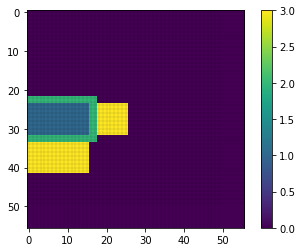

In [554]:
# joker,playground,sitting area
i = 0
while i <= 2:
    a = False
    while a == False:
        si = p[np.random.choice(len(p), 1, replace=False)[0]]
        ar = np.sum(p_array[si[0]:si[0]+8, si[1]]==1) == 4
        ac = np.sum(p_array[si[0], si[1]:si[1]+8]==1) == 4
        a = ar or ac
        if (a==True)*(avail_array[si[0], si[1]] != 3) == 1:
            public(si,3)
            i = i + 1
            if ar == True:
                p_array[si[0]:si[0]+8, si[1]] = 0
            else:
                p_array[si[0], si[1]:si[1]+8] = 0
        else:
            a = False
plot(avail_array)

In [555]:
avail_lattice = tg.to_lattice(avail_array, minbound=[0,0,0])
neigh_lattice = avail_lattice.apply_stencil(vn_stencil)

In [556]:
# definition of secondary spaces with 8*4 m2 (top starting point, index number)
def services_v(point,i):
    c = (8,4,1)
    avail_array[point[0]:point[0] + c[0], point[1]:point[1] + c[1]] = i
def services_h(point,i):
    c = (4,8,1)
    avail_array[point[0]:point[0] + c[0], point[1]:point[1] + c[1]] = i
def services(point,i,h,v):
    if h == True:
        services_h(point,i)
    else:
        services_v(point,i)

In [557]:
p = find_possible_p(neigh_lattice, two_array, avail_array, 2)
print(p)

[[22 18  0]
 [14  0  0]
 [14  2  0]
 [14  4  0]
 [14  6  0]
 [14  8  0]
 [14 10  0]]


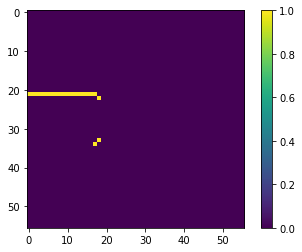

In [558]:
plt.imshow((neigh_lattice==2))
plt.colorbar()
plt.show()

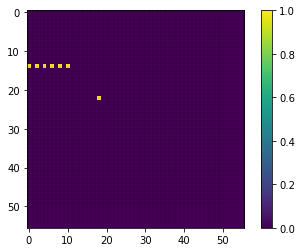

In [559]:
# array of possible points
p_array = np.zeros((width,length,1), dtype=int)
for i in range(len(p)):
    p_array[p[i][0], p[i][1]] = 1
plot(p_array)

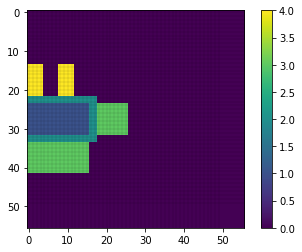

In [560]:
# add toilets & canteen unit (4*8) 
b = np.argwhere(p_array == 1)
i = 0
j = 0
while i <= 1:
    av = False
    while (av == False) and (j <= 20):
        bi = b[np.random.choice(len(b), 1, replace=False)[0]]
        ar = np.sum(p_array[bi[0]:bi[0]+4, bi[1]]==1) == 2
        ac = np.sum(p_array[bi[0], bi[1]:bi[1]+4]==1) == 2
        av = ar or ac
        if (av == True) * (avail_array[bi[0], bi[1]] == 0) == 1:
            services(bi,4,ar,ac)
            i = i + 1
            if ar == True:
                p_array[bi[0]:bi[0]+8, bi[1]] = 0
            else:
                p_array[bi[0], bi[1]:bi[1]+8] = 0
        else:
            av = False
            j = j + 1
    if j > 20:
        i = i + 1
plot(avail_array)

In [561]:
avail_lattice = tg.to_lattice(avail_array, minbound=[0,0,0])
k_array = np.zeros((width,length,1), dtype=int)
k_array[np.where(avail_lattice==3)] = 1
k_lattice = tg.to_lattice(k_array, minbound=[0,0,0])
neigh_lattice = k_lattice.apply_stencil(vn_stencil)

In [562]:
pf = find_possible_p(neigh_lattice, two_array, avail_array, 1)

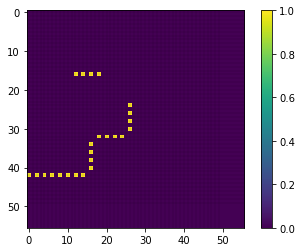

In [563]:
# array of possible points
p_array = np.zeros((width,length,1), dtype=int)

for i in range(len(pf)):
    p_array[pf[i][0], pf[i][1]] = 1
plot(p_array)


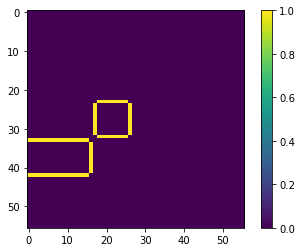

In [564]:
plt.imshow((neigh_lattice==1))
plt.colorbar()
plt.show()

[42  8  0]
1
4


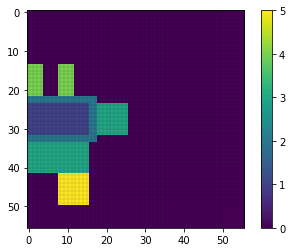

In [565]:
# add first aid
i = 0
j = 0
while i <= 0:
    a = False
    while (a == False) and (j <= 20):
        si = pf[np.random.choice(len(pf), 1, replace=False)[0]]
        ar = np.sum(p_array[si[0]:si[0]+8, si[1]]==1) == 4
        ac = np.sum(p_array[si[0], si[1]:si[1]+8]==1) == 4
        a = ar or ac
        if (a==True)*(avail_array[si[0], si[1]] == 0) == 1:
            public(si,5)
            i = i + 1
            print(si)
            print(np.sum(p_array[si[0]:si[0]+8, si[1]]==1))
            print(np.sum(p_array[si[0], si[1]:si[1]+8]==1))
            if ar == True:
                p_array[si[0]:si[0]+8, si[1]] = 0
            else:
                p_array[si[0], si[1]:si[1]+8] = 0
        else:
            a = False
            j = j + 1
    if j > 20:
        i = i + 1
plot(avail_array)

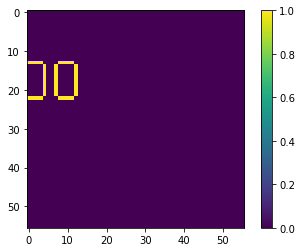

In [566]:
avail_lattice = tg.to_lattice(avail_array, minbound=[0,0,0])
k_array = np.zeros((width,length,1), dtype=int)
k_array[np.where(avail_lattice==4)] = 1
k_lattice = tg.to_lattice(k_array, minbound=[0,0,0])
neigh_lattice = k_lattice.apply_stencil(vn_stencil)

plt.imshow(neigh_lattice == 1)
plt.colorbar()
plt.show()
# avail_lattice = tg.to_lattice(avail_array, minbound=[0,0,0])
# neigh_lattice = avail_lattice.apply_stencil(vn_stencil)

In [567]:
# add kitchen
#pk = find_possible_p(neigh_lattice, two_array, avail_array, 1)
print(p)

[[22 18  0]
 [14  0  0]
 [14  2  0]
 [14  4  0]
 [14  6  0]
 [14  8  0]
 [14 10  0]]


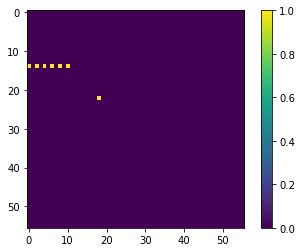

In [568]:
# array of possible points
p_array = np.zeros((width,length,1), dtype=int)
for i in range(len(p)):
    p_array[p[i][0], p[i][1]] = 1

plt.imshow(p_array == 1)
plt.colorbar()
plt.show()

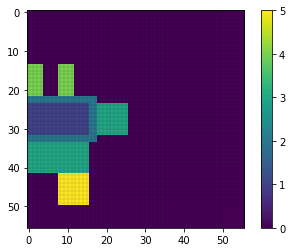

In [569]:
# kitchen
i = 0
j = 0
while i <= 0:
    a = False
    while (a == False) and (j <= 20):
        si = pk[np.random.choice(len(pk), 1, replace=False)[0]]
        ar = np.sum(p_array[si[0]:si[0]+8, si[1]]==1) == 4
        ac = np.sum(p_array[si[0], si[1]:si[1]+8]==1) == 4
        a = ar or ac
        if (a==True)*(avail_array[si[0], si[1]] == 0) == 1:
            public(si,6)
            i = i + 1
            print(si)
            print(np.sum(p_array[si[0]:si[0]+8, si[1]]==1))
            print(np.sum(p_array[si[0], si[1]:si[1]+8]==1))
            if ar == True:
                p_array[si[0]:si[0]+8, si[1]] = 0
            else:
                p_array[si[0], si[1]:si[1]+8] = 0
        else:
            a = False
            j = j + 1
    if j > 20:
        i = i + 1
plot(avail_array)